This notebook should be run on Google Colab.
<a href="https://colab.research.google.com/drive/1RXPpRM18gDh1KQ1ssPpPNVUwdGL7_w9H#scrollTo=6Uox52mtM8i0" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Process
In this notebook, I will train the book recommendation algorithms using two different packages: <a href="http://surpriselib.com/">Surprise</a> & <a href="https://cornac.readthedocs.io/en/latest/">Cornac</a>. 

## A. Import lbraries

In [1]:
!pip uninstall tensorflow -y
!pip install tensorflow-gpu==1.15
!apt install --allow-change-held-packages libcudnn7=7.4.1.5-1+cuda10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn7 is already the newest version (7.4.1.5-1+cuda10.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [2]:
!pip install cornac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

# Cornac imports
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader as CornacReader #Reader exists in both packages
from cornac.models import MostPop, MF, PMF, BPR, NeuMF, WMF, HPF, VAECF
from cornac.models import NMF as CornacNMF #NMF exists in both packages
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR

# Surprise imports
from surprise import BaselineOnly, KNNBasic, KNNWithMeans, SVDpp, SVD
from surprise import NMF as SurpriseNMF
from surprise import Dataset
from surprise import Reader as SurpriseReader
from surprise.model_selection import train_test_split
from surprise import accuracy


from collections import defaultdict
from scipy import stats
from numpy.linalg import norm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# set plot style: grey grid in the background:
sns.set(style="darkgrid")
pd.set_option("display.precision", 8)

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [5]:
# constants and initialization
item_threshold = 1
rating_threshold = 1.0 # needed for the cornac library
my_seed = 0
test_size = 0.2 # the percentage of "hold out" data that are used for testing
predict_col = "rating"
top_fraction = 0.2
train_way = "simple_split"
n_splits = 5
if train_way == "simple_split": n_splits = 1

rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy stuff

## C. Read files

In [6]:
user_events_file = 'https://raw.githubusercontent.com/SavvinaDaniil/UnfairnessOfPopularityBias/main/data/BX-Book-Ratings.csv'

# read user events
cols = ['user', 'book', 'rating']
df_events = pd.read_csv(user_events_file, sep=";", encoding="ISO-8859–1", names=cols, skiprows=1)
item_col = "book"
print('No. of user events: ' + str(len(df_events)))

No. of user events: 1149780


In [7]:
df_events.head()

,user,book,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


## D. Data analysis

In [8]:
def users_and_items(df_events, user_col, item_col):
    print('No. user events: ' + str(len(df_events)))
    print('No. items: ' + str(len(df_events[item_col].unique())))
    print('No. users: ' + str(len(df_events[user_col].unique())))
    print("\n")
def user_distribution(df_events, user_col, item_col):
    user_dist = df_events[user_col].value_counts() 
    num_users = len(user_dist)
    print('Mean '+item_col+'s per user: ' + str(np.round(user_dist.mean(),1))) 
    print('Min '+item_col+'s per user: ' + str(np.round(user_dist.min(),1))) 
    print('Max '+item_col+'s per user: ' + str(np.round(user_dist.max(),1)))
    print("\n")
    return user_dist, num_users
def item_distribution(df_events, user_col, item_col):
    item_dist = df_events[item_col].value_counts()
    num_items = len(item_dist)
    print('Mean users per '+item_col+': ' + str(np.round(item_dist.mean(),1))) 
    print('Min users per '+item_col+': ' + str(np.round(item_dist.min(),1))) 
    print('Max users per '+item_col+': ' + str(np.round(item_dist.max(),1))) 
    print("\n")
    return item_dist, num_items

In [9]:
users_and_items(df_events, "user", item_col)
user_dist, num_users = user_distribution(df_events, "user", item_col)
item_dist, num_items = item_distribution(df_events, "user", item_col)

No. user events: 1149780
No. items: 340556
No. users: 105283


Mean books per user: 10.9
Min books per user: 1
Max books per user: 13602


Mean users per book: 3.4
Min users per book: 1
Max users per book: 2502




FairBook cut down the dataset.

In [10]:
# This method return a dataframe in which the specified values are removed from a specific column. We can use it to generate the implicit/explicit dataset.
# To do this, we can remove the 0 or 1-10 values from the `Book-Rating` column.
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [11]:
df_events = filter_rows_by_values(df_events, predict_col, [0])


# statistics on explicit dataset
users_and_items(df_events, "user", item_col)
user_dist, num_users = user_distribution(df_events, "user", item_col)
item_dist, num_items = item_distribution(df_events, "user", item_col)

No. user events: 433671
No. items: 185973
No. users: 77805


Mean books per user: 5.6
Min books per user: 1
Max books per user: 8524


Mean users per book: 2.3
Min users per book: 1
Max users per book: 707




In [12]:
# To check if there is any user with more than toprate interaction in the preprocessed dataset
# The correct output will be zero
uid_value_counts = df_events['user'].value_counts()
print(f"The number of users with more than 200 interactions: {uid_value_counts[uid_value_counts > 200].count()}")

The number of users with more than 200 interactions: 144


In [13]:
# To remove the users with fewer than 5 interaction we first count the number of interactino per user and add a new column (`Count`) in the dataframe.
# This column shows the number of interaction per user in the dataset
users_counts = uid_value_counts.to_dict() #converts to dictionary
df_events['Count'] = df_events['user'].map(users_counts)

In [14]:
df_events = filter_rows_by_values(df_events, "Count", list(range(200, max(df_events['Count']) + 1)))

In [15]:
# new data statistics
users_and_items(df_events, "user", item_col)
user_dist, num_users = user_distribution(df_events, "user", item_col)
item_dist, num_items = item_distribution(df_events, "user", item_col)

No. user events: 364245
No. items: 156891
No. users: 77660


Mean books per user: 4.7
Min books per user: 1
Max books per user: 199


Mean users per book: 2.3
Min users per book: 1
Max users per book: 683




In [16]:
user_interaction, item_interaction = 1, 1

while user_interaction != 0 or item_interaction != 0:
    uid_value_counts = df_events["user"].value_counts()
    user_interaction = uid_value_counts[uid_value_counts < 5].count()

    users_counts = df_events["user"].value_counts()
    users_counts = users_counts.to_dict() #converts to dictionary
    df_events['Count'] = df_events["user"].map(users_counts)

    df_events = filter_rows_by_values(df_events, "Count", list(range(5)))

    # item side fewer than ds_rate cheking
    bid_value_counts = df_events[item_col].value_counts()
    item_interaction = bid_value_counts[bid_value_counts < 5].count()

    items_counts = df_events[item_col].value_counts()
    items_counts = items_counts.to_dict() #converts to dictionary
    df_events['Count'] = df_events[item_col].map(items_counts)

    df_events = filter_rows_by_values(df_events, "Count", list(range(5)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
# final data statistics
users_and_items(df_events, "user", item_col)
user_dist, num_users = user_distribution(df_events, "user", item_col)
item_dist, num_items = item_distribution(df_events, "user", item_col)

No. user events: 88552
No. items: 6921
No. users: 6358


Mean books per user: 13.9
Min books per user: 5
Max books per user: 153


Mean users per book: 12.8
Min users per book: 5
Max users per book: 350




In [18]:
del(df_events["Count"])

In [19]:

# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist) # turn the series into a dataframe
df_item_dist.columns = ['count']
df_item_dist['count'] /= num_users # basically the popularity of every item


In [20]:
df_item_dist.head()

,count
0316666343,0.05504876
0385504209,0.04356716
0312195516,0.03129915
0142001740,0.02956905
0060928336,0.02831079


In [21]:
def plot_data_distribution(item_dist, item_col, dividing = [False, 0], log = False, save = False, addition = ""):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        x0 = int(len(item_dist.values)*dividing[1])
        y = range(len(item_dist))
        plt.plot(y[:x0+1], item_dist.values[:x0+1], label = "Popular "+item_col+"s", linewidth = 5)
        plt.plot(y[x0:], item_dist.values[x0:], label = "Non Popular "+item_col+"s", linewidth = 5)
    else:
        plt.plot(item_dist.values)
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    add = ""
    if log:
        plt.xscale('log')
        plt.yscale('log')
        add = "_(log)"
    plt.xlabel(item_col+add, fontsize='14')
    plt.ylabel('Number of users' + add, fontsize='15')
    if save:
        if dividing[0]:
            plt.savefig('graphs/'+item_col+add+"_dist_div"+addition+".png", bbox_inches='tight')
        else:
            plt.savefig('graphs/'+item_col+add+"_dist"+addition+".png", bbox_inches='tight')
    plt.show(block=True)
def plot_popularity_distribution(pop_fraq, item_col, dividing = [False,0], save = False, addition = ""):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        y = range(len(pop_fraq))
        x0 = int(len(y)*dividing[1]) 
        x1 = int(len(y)*(1-dividing[1]))
        x= sorted(pop_fraq)
        plt.plot(y[:x0+1],x[:x0+1], label="LowMS users", linewidth = 5)
        plt.plot(y[x0:x1+1],x[x0:x1+1], label = "MedMS users", linewidth = 5)
        plt.plot(y[x1:],x[x1:], label = "HighMS users", linewidth =5)
    else:
        plt.plot(sorted(pop_fraq))
    plt.xlabel('User', fontsize='15')
    plt.xticks(fontsize='13')
    plt.ylabel('Ratio of popular '+item_col+'s', fontsize='15')
    plt.yticks(fontsize='13')
    plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular '+item_col+'s')
    plt.legend(fontsize='15')
    #plt.savefig('data/ECIR/user_artist_ratio.png', dpi=300, bbox_inches='tight')
    if save:
        if dividing[0]:
            plt.savefig('graphs/'+item_col+"_pop_dist_div"+addition+".png", bbox_inches='tight')
        else:
            plt.savefig('graphs/'+item_col+"_pop_dist"+addition+".png", bbox_inches='tight')
    plt.show(block=True)


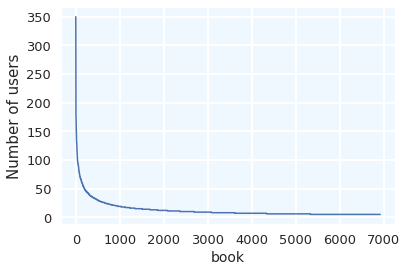

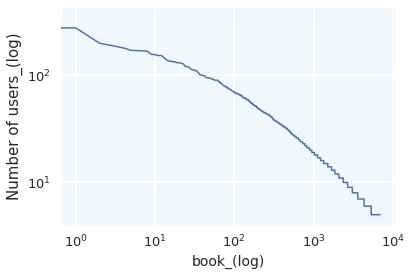

In [22]:
plot_data_distribution(item_dist, item_col)
plot_data_distribution(item_dist, item_col, [False, 0],True)

## E. Popularity in the data

In [23]:
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 1384


In [24]:
def calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col):
    pop_count = [] # number of top items per user
    user_hist = [] # user history sizes
    pop_fraq = [] # relative number of top items per user
    pop_item_fraq = [] # average popularity of items in user profiles
    i=0
    for u, df in df_events.groupby(user_col):
        no_user_items = len(set(df[item_col]))
        no_user_pop_items = len(set(df[item_col]) & set(top_item_dist.index))
        pop_count.append(no_user_pop_items)
        user_hist.append(no_user_items) 
        pop_fraq.append(no_user_pop_items / no_user_items)
        user_pop_item_fraq = sum(item_dist[df[item_col]] / num_users) / no_user_items
        pop_item_fraq.append(user_pop_item_fraq)
        i+=1
        if i%1000==0:
            print(i)
    #output = open('data/'+item_col+'_pop_fraq.pkl', 'wb')
    #pkl.dump(pop_fraq, output)
    #output.close()

    #output = open('data/'+item_col+'_user_hist.pkl', 'wb')
    #pkl.dump(user_hist, output)
    #output.close()

    #output = open('data/'+item_col+'_pop_count.pkl', 'wb')
    #pkl.dump(pop_count, output)
    #output.close()

    #output = open('data/'+item_col+'_pop_item_fraq.pkl', 'wb')
    #pkl.dump(pop_item_fraq, output)
    #output.close()

    return pop_count,user_hist,pop_fraq, pop_item_fraq

In [25]:
pop_count,user_hist,pop_fraq, pop_item_fraq = calculate_popularity(df_events, top_item_dist, item_dist, num_users, "user", item_col)

1000
2000
3000
4000
5000
6000


In [26]:
def plot_popularity_distribution(pop_fraq, item_col, dividing = [False,0], save = False, addition = ""):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    if dividing[0]:
        y = range(len(pop_fraq))
        x0 = int(len(y)*dividing[1]) 
        x1 = int(len(y)*(1-dividing[1]))
        x= sorted(pop_fraq)
        plt.plot(y[:x0+1],x[:x0+1], label="LowMS users", linewidth = 5)
        plt.plot(y[x0:x1+1],x[x0:x1+1], label = "MedMS users", linewidth = 5)
        plt.plot(y[x1:],x[x1:], label = "HighMS users", linewidth =5)
    else:
        plt.plot(sorted(pop_fraq))
    plt.xlabel('User', fontsize='15')
    plt.xticks(fontsize='13')
    plt.ylabel('Ratio of popular '+item_col+'s', fontsize='15')
    plt.yticks(fontsize='13')
    plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular '+item_col+'s')
    plt.legend(fontsize='15')
    #plt.savefig('data/ECIR/user_artist_ratio.png', dpi=300, bbox_inches='tight')
    if save:
        if dividing[0]:
            plt.savefig('graphs/'+item_col+"_pop_dist_div"+addition+".png", bbox_inches='tight')
        else:
            plt.savefig('graphs/'+item_col+"_pop_dist"+addition+".png", bbox_inches='tight')
    plt.show(block=True)

def plot_Lorenz(movs,cdf, item_col = "movie", save = False, addition = ""):
    def f(t):
        return t
    plt.plot(movs*100, cdf*100, linewidth = 3, color = "red", label = "L(x) actual")
    plt.plot(movs*100, movs*100, linewidth = 3, color = "blue", label = "L(x) = x, distributional equality")
    plt.xlabel("100x% least consumed items")
    plt.ylabel("100y% of total amount of consumptions")
    section = movs*100
    plt.legend()
    plt.fill_between(section, f(section), color = "lightgrey")
    plt.fill_between(movs*100, cdf*100, color = "gray")
    if save:
        plt.savefig('graphs/'+item_col+"_data_Lorenz"+addition+".png", bbox_inches='tight')
    plt.show(block=True)

def plot_profile_size_vs_popularity(pop_metric, user_hist, way, item_col, save = False, addition = ""):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.grid(color = "w",linewidth = 2 )
    slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_metric)
    print('R-value: ' + str(r_value))
    line = slope * np.array(user_hist) + intercept
    plt.plot(user_hist, pop_metric, 'o', user_hist, line)
    plt.xlabel('User profile size', fontsize='15')
    plt.xticks(fontsize='13')
    if way == "count":
        ylabel = "Number of popular "+item_col+"s"
    elif way == "percentage":
        ylabel = 'Percentage of popular '+item_col+'s'
    else:
        ylabel = "Average popularity of "+item_col+"s"
    plt.ylabel(ylabel, fontsize='15')
    plt.yticks(fontsize='13')
    #plt.savefig('data/ECIR/corr_user_pop.png', dpi=300, bbox_inches='tight')
    if save:
        plt.savefig('graphs/'+item_col+"_"+way+"_vs_size"+addition+".png", bbox_inches='tight')
    plt.show(block=True)

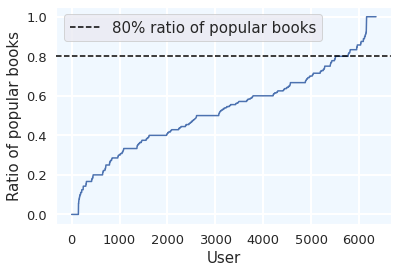

R-value: 0.923043590336


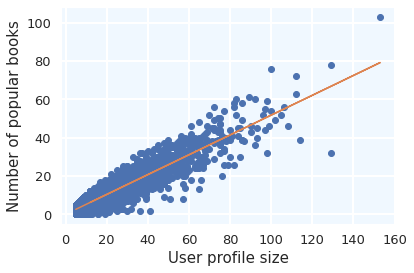

R-value: -0.013155544625724313


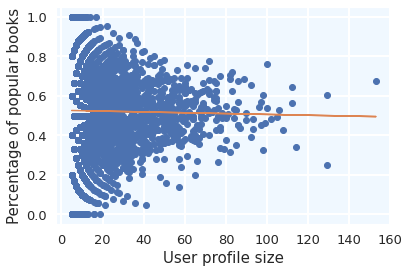

R-value: -0.033575222226251665


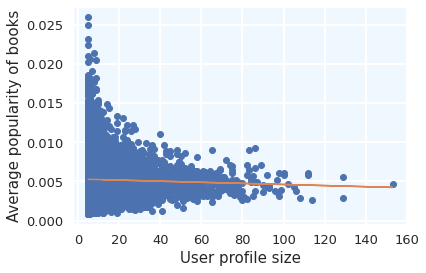

In [27]:
plot_popularity_distribution(pop_fraq, item_col)
plot_profile_size_vs_popularity(pop_count,user_hist, "count", item_col)
plot_profile_size_vs_popularity(pop_fraq,user_hist, "percentage", item_col)
plot_profile_size_vs_popularity(pop_item_fraq,user_hist, "average", item_col)

## F. User groups

In [28]:
def sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq, by = "pop_fraq"):
    user_dist = user_dist.sort_index()
    user_dist_sorted = pd.DataFrame(data = user_dist)
    
    user_dist_sorted.columns = ["count"]
    
    user_dist_sorted["pop_count"] = pop_count
    user_dist_sorted["user_hist"] = user_hist
    user_dist_sorted["pop_fraq"] = pop_fraq
    user_dist_sorted["pop_item_fraq"] = pop_item_fraq
    
    user_dist_sorted = user_dist_sorted.sort_values(by=[by])
    return user_dist_sorted

def split(user_dist_sorted, top_fraction):
    low, med, high = np.split(user_dist_sorted, [int(top_fraction*len(user_dist_sorted)), int((1-top_fraction)*len(user_dist_sorted))])
    return low, med, high
def calculate_group_characteristics(low, med, high):
    low_profile_size = low.user_hist.mean()
    med_profile_size = med.user_hist.mean()
    high_profile_size = high.user_hist.mean()
    
    low_nr_users = len(low)
    med_nr_users = len(med)
    high_nr_users = len(high)
    
    low_GAP = low.pop_item_fraq.mean()
    med_GAP = med.pop_item_fraq.mean()
    high_GAP = high.pop_item_fraq.mean()
    
    return low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP

In [29]:
user_dist_sorted = sort_user_dist(user_dist,pop_count, user_hist,pop_fraq,pop_item_fraq)
low, med, high = split(user_dist_sorted, top_fraction)
low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP = calculate_group_characteristics(low, med, high)

In [30]:
print('LowMS GAP: ' + str(low_GAP))
print('MedMS GAP: ' + str(med_GAP))
print('HighMS GAP: ' + str(high_GAP))

LowMS GAP: 0.0026179945388530904
MedMS GAP: 0.005115376310090785
HighMS GAP: 0.008074644552000724


In [31]:
print(low.pop_fraq.mean(), med.pop_fraq.mean(), high.pop_fraq.mean())
print(low.pop_fraq.std(), med.pop_fraq.std(), high.pop_fraq.std())

0.2090561732239313 0.5270867500527463 0.828974321499183
0.10097329694007061 0.10192456254933661 0.08864008055173113


In [32]:
def plot_group_characteristics(low_nr, med_nr, high_nr, way, item_col, save = False, addition = ""):
    plt.figure()
    ax = plt.axes()
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['left'].set_zorder(0)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    
    ax.set_facecolor("aliceblue")
    plt.bar(np.arange(3), [low_nr, med_nr, high_nr])
    plt.xticks(np.arange(3), ['LowMS', 'MedMS', 'HighMS'])
    plt.xlabel('User group')
    if way=="size":
        ylabel = 'Average user profile size'
    else:
        ylabel = "Number of users per group"
    plt.ylabel(ylabel)
    
    print('LowMS: ' + str(low_nr))
    print('MedMS: ' + str(med_nr))
    print('HighMS: ' + str(high_nr))
    if save:
        plt.savefig('graphs/'+item_col+"_"+way+"_groups"+addition+".png", bbox_inches='tight')
    plt.show(block=True)

LowMS: 1271
MedMS: 3815
HighMS: 1272


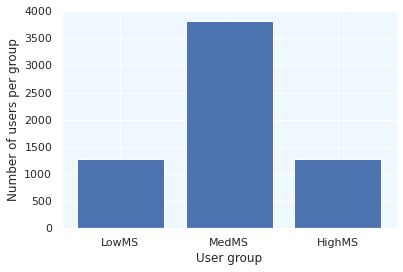

LowMS: 10.991345397324942
MedMS: 16.222804718217564
HighMS: 9.977987421383649


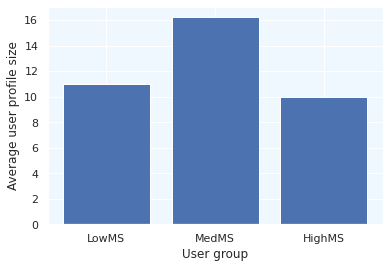

In [33]:
plot_group_characteristics(low_nr_users, med_nr_users, high_nr_users, way = "number", item_col = item_col)
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size, way = "size", item_col = item_col)

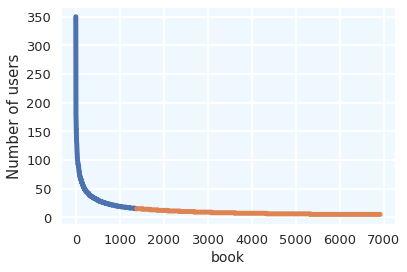

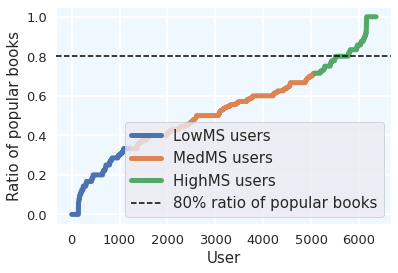

In [34]:
plot_data_distribution(item_dist, item_col, dividing = [True, top_fraction], log = False)
plot_popularity_distribution(pop_fraq, item_col, dividing = [True,top_fraction])

## G. Recommendation

In [35]:
df_events.head()

,user,book,rating
182,276847,3426029553,8
210,276847,3551551677,10
211,276847,3551551685,10
212,276847,3551551693,10
213,276847,3551551936,10


### G.1 Cornac

In [36]:
df_events_cornac = df_events.copy()
mapping_dict = {} # Create a dictionary that maps each ISBN to an integer.
i=0
for book in df_events_cornac[item_col].unique():
    mapping_dict[book] = i
    i+=1
df_events_cornac[item_col] = df_events_cornac[item_col].map(lambda x: mapping_dict.get(x,x)) # Map in the ratings file

In [37]:
df_events_cornac.user = df_events_cornac.user.astype("string")
df_events_cornac[item_col] = df_events_cornac[item_col].astype("string")

In [38]:
df_item_dist_cornac = df_item_dist.rename(index = mapping_dict)

In [39]:
data = list(df_events_cornac[["user",item_col,predict_col]].to_records(index = False))

In [40]:
# Split the data based on ratio
rs = RatioSplit(data=data, test_size=test_size, rating_threshold=rating_threshold, seed=0)

In [41]:
# initialize models, here we are comparing: simple, traditional, and neural networks based models
models = [
          # 1: Random
          # 2: MostPop
          MostPop(),
          # 3: UserKNN
          # 4: BPR
          BPR(k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123),
          # 5: MF
          MF(k=30, max_iter=100, learning_rate=0.01, lambda_reg=0.001, seed=123),
          # 6: PMF
          PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001),
          # 7: NMF
          CornacNMF(k=15, max_iter=50, learning_rate=0.005, lambda_u=0.06, lambda_v=0.06, lambda_bu=0.02, lambda_bi=0.02, use_bias=False, verbose=True, seed=123),
          # 8: WMF
          WMF(k=50, max_iter=50, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01, verbose=True, seed=123),
          # 9: PF
          HPF(k=50, seed=123, hierarchical=False, name="PF"),
          # 10: NueMF
          NeuMF(num_factors=8, layers=[32, 16, 8], act_fn="tanh", num_epochs=1, num_neg=3, batch_size=256, lr=0.001, seed=42, verbose=True),
          # 11: VAECF
          VAECF(k=10, autoencoder_structure=[20], act_fn="tanh", likelihood="mult", n_epochs=100, batch_size=100, learning_rate=0.001, beta=1.0, seed=123, use_gpu=True, verbose=True)
          ]

In [42]:
# define metrics to evaluate the models
metrics = [MAE(), MSE(), RMSE(), AUC(), MAP(), MRR(), 
           Precision(k=5), Precision(k=10), Precision(k=20), Precision(k=50),
           Recall(k=5), Recall(k=10), Recall(k=20), Recall(k=50),
           NDCG(k=5), NDCG(k=10), NDCG(k=20), NDCG(k=50),
           FMeasure(k=5), FMeasure(k=10), FMeasure(k=20), FMeasure(k=50)]

# put it together in an experiment, voilà!
exp = cornac.Experiment(eval_method=rs, models=models, metrics=metrics, user_based=True)
exp.run()

  0%|          | 0/50 [00:00<?, ?it/s]

Optimization finished!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!
Learning...
Learning completed!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]


TEST:
...
        |    MAE |     MSE |   RMSE |    AUC |  F1@10 |  F1@20 |   F1@5 |  F1@50 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@5 | NDCG@50 | Precision@10 | Precision@20 | Precision@5 | Precision@50 | Recall@10 | Recall@20 | Recall@5 | Recall@50 | Train (s) | Test (s)
------- + ------ + ------- + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------ + ------- + ------------ + ------------ + ----------- + ------------ + --------- + --------- + -------- + --------- + --------- + --------
MostPop | 2.5202 | 10.0391 | 2.7988 | 0.6544 | 0.0105 | 0.0100 | 0.0099 | 0.0091 | 0.0147 | 0.0350 |  0.0175 |  0.0223 | 0.0141 |  0.0334 |       0.0076 |       0.0063 |      0.0092 |       0.0051 |    0.0253 |    0.0397 |   0.0151 |    0.0820 |    0.0135 |  17.8967
BPR     | 6.5658 | 46.4381 | 6.6616 | 0.6775 | 0.0105 | 0.0102 | 0.0099 | 0.0092 | 0.0148 | 0.0350 |  0.0175 |  0.0226 | 0.0141 |  0.0334 |       0.0076 |       0.0064 |      0.0092 |     

In [43]:
def compute_user_knn(C):
  ctime = time.time()
  print("Training User-based Collaborative Filtering...", )

  sim = C.dot(C.T)
  norms = [norm(C[i]) for i in range(C.shape[0])]

  for i in tqdm(range(C.shape[0])):
    sim[i][i] = 0.0
    for j in range(i+1, C.shape[0]):
      sim[i][j] /= (norms[i] * norms[j])
      sim[j][i] /= (norms[i] * norms[j])

  print("Done. Elapsed time:", time.time() - ctime, "s")
  rec_score = sim.dot(C)
  return rec_score

In [44]:
def read_training_data():
  training_matrix = np.zeros((rs.train_set.matrix.shape[0], rs.train_set.matrix.shape[1]))
  for uid in tqdm(rs.train_set.uid_map.values()):
    for iid in rs.train_set.iid_map.values():
      training_matrix[uid, iid] = rs.train_set.matrix[uid, iid]
  return training_matrix

In [45]:
# creating users-books rating matrix (will be used for User-KNN algorithm)
training_matrix = read_training_data()

100%|██████████| 6358/6358 [19:31<00:00,  5.43it/s]


In [46]:
# running User-KNN algorithms and getting the user-book scores
user_knn_scores = compute_user_knn(training_matrix)

Training User-based Collaborative Filtering...


100%|██████████| 6358/6358 [00:23<00:00, 275.81it/s] 


Done. Elapsed time: 35.24323081970215 s


In [47]:
# UserKNN recommendation algorithm
def get_top_n_UserKNN(n=10):
    print("User-KNN model is selected:")
    top_n = defaultdict(list)
    # test_items = list(rs.test_set.iid_map.keys())
    for uid in rs.train_set.uid_map.values():
      user_id = list(rs.train_set.user_ids)[uid]
      top_n_items_idxs = list(reversed(user_knn_scores[uid].argsort()))[:n]
      for iid in top_n_items_idxs:
        item_id = list(rs.train_set.item_ids)[iid]
        top_n[int(user_id)].append((int(item_id), user_knn_scores[uid][iid]))
    return top_n

In [48]:
def get_top_n(algo_name, n=10):
  for model in exp.models:
    if model.name == algo_name:
      print(model.name + " model is selected:")
      top_n = defaultdict(list)
      for uid in model.train_set.uid_map.values():
        user_id = list(model.train_set.user_ids)[uid]
        try:
          item_rank = model.rank(user_idx=uid)[0] # model.rank: item rank, item_score
        except:
          item_rank = model.rank(user_idx=int(uid))[0]
        # collect top N items
        item_rank_top = item_rank[:n]
        for iid in item_rank_top:
          item_id = list(model.train_set.item_ids)[iid]
          top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [61]:
len(list(exp.models[2].train_set.uid_map.values()))

6358

In [81]:
len(rs.test_set.user_ids)

5376

In [64]:
for uid in range(6358): 
  nr_items = len(exp.models[3].rank(user_idx=uid)[0])
  if nr_items!=6921:
    print(nr_items)

In [85]:
def get_top_n_test_users(algo_name, n=10):
  for model in exp.models:
    if model.name == algo_name:
      print(model.name + " model is selected:")
      top_n = defaultdict(list)
      for uid in rs.test_set.uid_map.values():
        user_id = list(rs.train_set.user_ids)[uid]
        try:
          item_rank = model.rank(user_idx=uid)[0] # model.rank: item rank, item_score
        except:
          item_rank = model.rank(user_idx=int(uid))[0]
        # collect top N items
        item_rank_top = item_rank[:n]
        for iid in item_rank_top:
          item_id = list(model.train_set.item_ids)[iid]
          top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [212]:
def get_top_n_like_surprise(algo_name, n=10):
  for model in exp.models:
    if model.name == algo_name:
      print(model.name + " model is selected:")
      top_n = defaultdict(list)
      for uid in rs.test_set.uid_map.values():
        user_id = list(rs.train_set.user_ids)[uid]
        user_items_in_the_test_set = rs.test_set.user_data[uid][0] 
        
        item_rank = model.rank(user_idx=uid, item_indices = user_items_in_the_test_set)[0] # model.rank: item rank, item_score, with inside encoding
        #item_rank = [x for x in item_rank if x in user_items_in_the_test_set]
          

        # except:
        #   item_rank = model.rank(user_idx=int(uid))[0]
        # collect top N items
        item_rank_top = item_rank[:n]
        # if int(user_id) == 244056:
        #   print(user_items_in_the_test_set)
        #   print(item_rank_top)
        for iid in item_rank_top:
          item_id = list(rs.train_set.item_ids)[iid] #correct
          # if int(user_id) == 244056:
          #   print(item_id)
          top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [209]:
vaecf_sur = get_top_n_like_surprise("VAECF")

VAECF model is selected:
[4415, 1274]
[1274 4415]
658
702


KeyboardInterrupt: ignored

In [210]:
list(exp.models[-1].train_set.item_ids)[1274]

'658'

In [189]:
rs.train_set.uid_map["244056"]

4005

In [190]:
rs.test_set.uid_map["244056"]

4005

In [192]:
rs.train_set.user_data[4005]

([3548, 2060, 1897, 6677, 2270], [9.0, 8.0, 10.0, 7.0, 8.0])

In [198]:
list(rs.train_set.item_ids)[1274]

'3705'

In [200]:
list(rs.train_set.user_ids)[4005]

'244056'

In [203]:
vaecf_sur[244056]

[(658, 4.5472938e-05), (702, 7.335381e-06)]

In [185]:
df_events_cornac[df_events_cornac.user=="244056"]

,user,book,rating
1018131,244056,4279,10
1018133,244056,2393,9
1018135,244056,701,10
1018137,244056,3396,7
1018138,244056,3705,10
1018142,244056,1749,8
1018144,244056,2015,8


In [167]:
rs.train_set.user_data[4005]

([3548, 2060, 1897, 6677, 2270], [9.0, 8.0, 10.0, 7.0, 8.0])

In [169]:
rs.test_set.user_data[4005]

([4415, 1274], [10.0, 10.0])

In [175]:
top_n[244056]

[(658, 21), (702, 8)]

In [173]:
low.index[0]

50823

In [213]:
# random recommendation algorithm
def get_top_n_random(n=10):
    print("Random model is selected:")
    top_n = defaultdict(list)
    test_items = list(rs.test_set.iid_map.keys())
    for uid in rs.train_set.uid_map.values():
      if uid not in top_n.keys():
        user_id = list(rs.train_set.user_ids)[uid]
        for i in range(0, n):
          top_n[int(user_id)].append((int(rd.choice(test_items)), i))
    return top_n

In [214]:
algo_names = ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']

i = 0
low_rec_gap_list = [] # one entry per algorithmus
medium_rec_gap_list = []
high_rec_gap_list = []

for i in range(0, len(algo_names)):
    df_item_dist_cornac[algo_names[i]] = 0
    low_rec_gap = 0
    medium_rec_gap = 0
    high_rec_gap = 0
    
    if algo_names[i] == 'Random':
      top_n = get_top_n_random(n=10)
    elif algo_names[i] == 'UserKNN':
      top_n = get_top_n_UserKNN(n=10)
    else:
      top_n = get_top_n_like_surprise(algo_names[i], n=10)
    low_count = 0
    med_count = 0
    high_count = 0
    for uid, user_ratings in top_n.items():
        iid_list = []
        for (iid, _) in user_ratings:
            df_item_dist_cornac.loc[iid, algo_names[i]] += 1
            iid_list.append(iid)
        gap = sum(df_item_dist_cornac["count"].loc[iid_list]) / len(iid_list)
        if uid in low.index:
            low_rec_gap += gap
            low_count += 1
        elif uid in med.index:
            medium_rec_gap += gap
            med_count += 1
        elif uid in high.index:
            high_rec_gap += gap
            high_count += 1
        else:
          print("hi")
    low_rec_gap_list.append(low_rec_gap / low_count)
    medium_rec_gap_list.append(medium_rec_gap / med_count)
    high_rec_gap_list.append(high_rec_gap / high_count)
    i += 1 # next algorithm

Random model is selected:
MostPop model is selected:
User-KNN model is selected:
MF model is selected:
PMF model is selected:
BPR model is selected:
NMF model is selected:
WMF model is selected:
PF model is selected:
NeuMF model is selected:
VAECF model is selected:


### Cornac results.

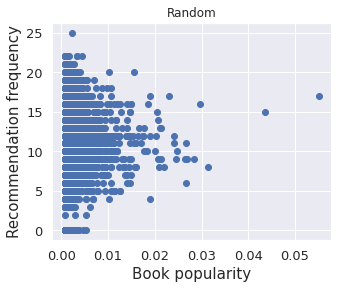

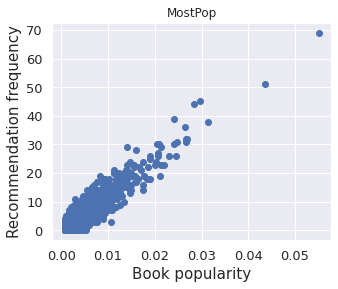

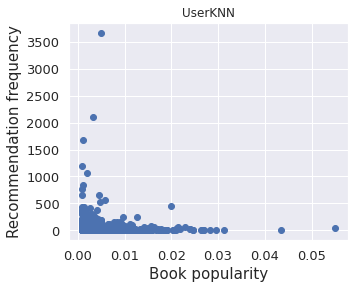

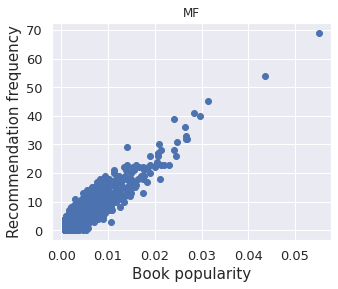

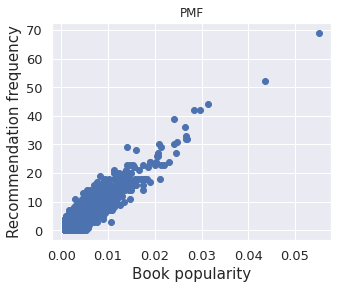

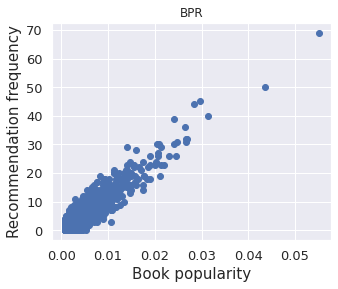

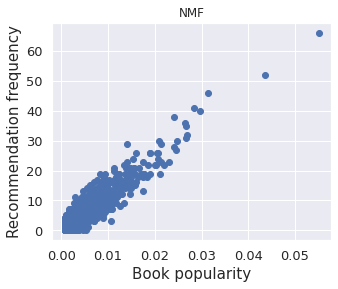

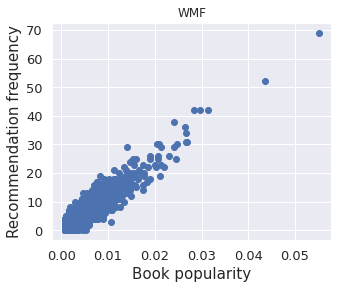

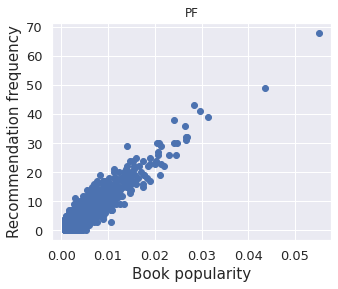

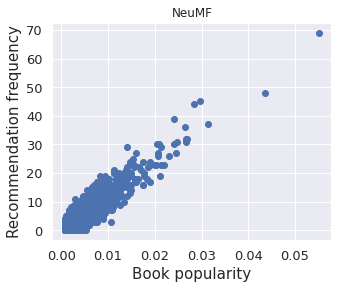

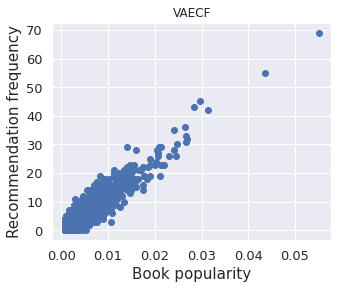

In [215]:
sns.set(rc = {'figure.figsize':(5,4)})
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist_cornac["count"]
    y = df_item_dist_cornac[algo_names[i]]

    plt.plot(x, y, 'o')
    plt.title(algo_names[i])
    plt.xlabel('Book popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')

In [216]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algo_names)):
    low_gap_vals.append((low_rec_gap_list[i] - low_GAP) / low_GAP * 100)
    medium_gap_vals.append((medium_rec_gap_list[i] - med_GAP) / med_GAP * 100)
    high_gap_vals.append((high_rec_gap_list[i] - high_GAP) / high_GAP * 100)

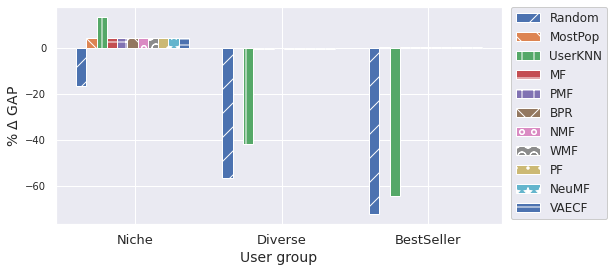

In [217]:
sns.set(rc = {'figure.figsize':(8,4)})

# set width of bar
barWidth = 0.07

# set height of bar
bars1 = [low_gap_vals[0], medium_gap_vals[0], high_gap_vals[0]]
bars2 = [low_gap_vals[1], medium_gap_vals[1], high_gap_vals[1]]
bars3 = [low_gap_vals[2], medium_gap_vals[2], high_gap_vals[2]]
bars4 = [low_gap_vals[3], medium_gap_vals[3], high_gap_vals[3]]
bars5 = [low_gap_vals[4], medium_gap_vals[4], high_gap_vals[4]]
bars6 = [low_gap_vals[5], medium_gap_vals[5], high_gap_vals[5]]
bars7 = [low_gap_vals[6], medium_gap_vals[6], high_gap_vals[6]]
bars8 = [low_gap_vals[7], medium_gap_vals[7], high_gap_vals[7]]
bars9 = [low_gap_vals[8], medium_gap_vals[8], high_gap_vals[8]]
bars10 = [low_gap_vals[9], medium_gap_vals[9], high_gap_vals[9]]
bars11 = [low_gap_vals[10], medium_gap_vals[10], high_gap_vals[10]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
r11 = [x + barWidth for x in r10]
# r12 = [x + barWidth for x in r11]
# r13 = [x + barWidth for x in r12]

# ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--"]
# Make the plot
plt.bar(r1, bars1, width=barWidth, label='Random', hatch=patterns[0])
plt.bar(r2, bars2, width=barWidth, label='MostPop', hatch=patterns[1])
plt.bar(r3, bars3, width=barWidth, label='UserKNN', hatch=patterns[2])
plt.bar(r4, bars4, width=barWidth, label='MF', hatch=patterns[3])
plt.bar(r5, bars5, width=barWidth, label='PMF', hatch=patterns[4])
plt.bar(r6, bars6, width=barWidth, label='BPR', hatch=patterns[5])
plt.bar(r7, bars7, width=barWidth, label='NMF', hatch=patterns[6])
plt.bar(r8, bars8, width=barWidth, label='WMF', hatch=patterns[7])
plt.bar(r9, bars9, width=barWidth, label='PF', hatch=patterns[8])
plt.bar(r10, bars10, width=barWidth, label='NeuMF', hatch=patterns[9])
plt.bar(r11, bars11, width=barWidth, label='VAECF', hatch=patterns[10])

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='14')
plt.ylabel('% $\Delta$ GAP', fontsize='14')
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ['Niche', 'Diverse', 'BestSeller'], fontsize='13')
plt.yticks(fontsize='10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
plt.show()

### G.2 Surprise

In [36]:
print('Min rating: ' + str(df_events[predict_col].min()))
print('Max rating: ' + str(df_events[predict_col].max()))

Min rating: 1
Max rating: 10


In [37]:
df_events_surprise = df_events.copy()
for col in df_events.columns:
  if (col!="user") and (col!=predict_col) and (col!=item_col):
    df_events_surprise = df_events.drop(col, axis=1)

In [38]:
df_events_surprise.head()

,user,book,rating
182,276847,3426029553,8
210,276847,3551551677,10
211,276847,3551551685,10
212,276847,3551551693,10
213,276847,3551551936,10


In [39]:
reader = SurpriseReader(rating_scale=(df_events_surprise[predict_col].min(), df_events_surprise[predict_col].max()))

In [40]:
data = Dataset.load_from_df(df_events_surprise, reader)

In [41]:
trainset, testset = train_test_split(data, test_size = test_size, random_state = my_seed)

In [ ]:
#%%
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

def get_top_n_random(testset, item_dist, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for i in range(0, 10):
                top_n[uid].append((rd.choice(item_dist.index), i))
    return top_n



def get_top_n_mp(testset, item_dist, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for iid, count in item_dist[:n].items():
                top_n[uid].append((iid, count))
    return top_n

In [42]:
# def get_top_n(predictions, n=10):
#     # First map the predictions to each user.
#     top_n = defaultdict(list)
#     for uid, iid, true_r, est, _ in predictions:
#         top_n[uid].append((iid, est))
#     # Then sort the predictions for each user and retrieve the k highest ones.
#     for uid, user_ratings in top_n.items():
#         user_ratings.sort(key=lambda x: x[1], reverse=True)
#         top_n[uid] = user_ratings[:n]
#     return top_n

In [226]:
alg = SurpriseNMF(n_factors = 15)
alg.fit(trainset)

In [43]:
anti_testset = trainset.build_anti_testset()

In [47]:
len(anti_testset)

43932877

In [49]:
len(testset)

17711

In [53]:
trainset.n_ratings

70841

In [57]:
test_users = np.unique([x[0] for x in testset])

In [58]:
len([x for x in anti_testset if x[0] in test_users])

37011722

In [ ]:
def train_algorithms_surprise(df_item_dist, trainset, testset, item_dist, no_users, low_users, medium_users, high_users):
    sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
    # είδος αποστασης=κοσαιν, ειδος κνν = χρηστη
    algos = [] # Random and MostPopular is calculated by default
    algos.append(None)#Random())
    algos.append(None)#MostPopular())
    algos.append(BaselineOnly()) #αυτο το UserItemAvg, τι ειναι?
    algos.append(KNNBasic(sim_options = sim_users, k=40)) 
    algos.append(KNNBasic(sim_options = {'name': 'cosine', 'user_based': False}, k=40)) 
    algos.append(KNNWithMeans(sim_options = sim_users, k=40)) 
    algos.append(SurpriseNMF(n_factors = 15))
    algos.append(SVDpp(n_factors = 15))
    algo_names = ['Random',
                  'MostPopular',
                  'UserItemAvg',
                  'UserKNN',
                  #"ItemKNN",
                  'UserKNNAvg',
                  'NMF',
                  'SVDpp']
    
    i = 0
    low_rec_gap_list = [] # one entry per algorithmus
    medium_rec_gap_list = []
    high_rec_gap_list = []
    start = time.time()
    for i in range(0, len(algo_names)): #για καθε αλγοριθμο
        print("~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~")
        df_item_dist[algo_names[i]] = 0 #προσθετω στηλη στο ποπιουλαριτι για τον αλγοριθμο i 
        low_rec_gap = 0
        medium_rec_gap = 0
        high_rec_gap = 0
        
        # get accuracy for personalized approaches
        if algo_names[i] != 'Random' and algo_names[i] != 'MostPopular': #για μη χαζους αλγοριθμους
            algos[i].fit(trainset) #κανεις φιτ
            predictions = algos[i].test(testset) #προβλεπεις
            print(algo_names[i])#λες τελειωσε ο ταδε αλγοριθμος
            #get_mae_of_groups(predictions, low_users, medium_users, high_users) #υπολογιζεις τα λαθη και τα τυπωνεις
        
        # get top-n items and calculate gaps for all algorithms
        # κανεις προτασεις αναλογα τις προβλεψεις
        if algo_names[i] == 'Random':
            top_n = get_top_n_random(testset, item_dist, n=10)
        elif algo_names[i] == 'MostPopular':
            top_n = get_top_n_mp(testset, item_dist, n=10)
        else:
            top_n = get_top_n(predictions, n=10)
        #υπολογιζεις τα gap
        low_count = 0
        med_count = 0
        high_count = 0
        for uid, user_ratings in top_n.items():
            iid_list = []
            for (iid, _) in user_ratings:
                df_item_dist.loc[iid, algo_names[i]] += 1
                iid_list.append(iid)
            gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
            if uid in low_users.index:
                low_rec_gap += gap
                low_count += 1
            elif uid in medium_users.index:
                medium_rec_gap += gap
                med_count += 1
            elif uid in high_users.index:
                high_rec_gap += gap
                high_count += 1
        low_rec_gap_list.append(low_rec_gap / low_count)
        medium_rec_gap_list.append(medium_rec_gap / med_count)
        high_rec_gap_list.append(high_rec_gap / high_count)
        i += 1 # next algorithm
        end = time.time()
        print("It took " + str(np.round(end-start)) + " seconds.")
        start = time.time()
    return df_item_dist, low_rec_gap_list, medium_rec_gap_list, high_rec_gap_list

In [ ]:
df_item_dist_surprise, low_rec_gap_list_surprise, medium_rec_gap_list_surprise, high_rec_gap_list_surprise = train_algorithms_surprise(df_item_dist, trainset, testset, item_dist, num_users, low, med, high)

~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
It took 23.0 seconds.
~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
It took 29.0 seconds.
~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
Estimating biases using als...
UserItemAvg
It took 11.0 seconds.
~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNN
It took 14.0 seconds.
~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNNAvg
It took 15.0 seconds.
~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
Computing the cosine similarity matrix...
Done computing similarity matrix.
NMF
It took 11.0 seconds.
~~~~~~~~~~~~~~~~NEW~~~~~~~~~~~~~~~~~
SVDpp
It took 16.0 seconds.


In [ ]:
#%%
algo_names = ['Random',
                  'MostPopular',
                  'UserItemAvg',
                  'UserKNN',
                  #"ItemKNN",
                  'UserKNNAvg',
                  'NMF',
                  'SVDpp']
for alg in algo_names:
    df_item_dist_surprise[alg] = df_item_dist_surprise[alg]/n_splits

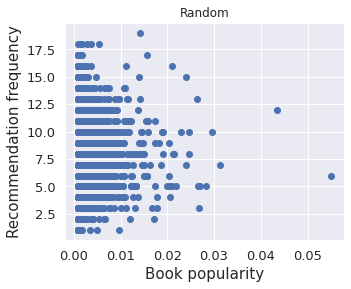

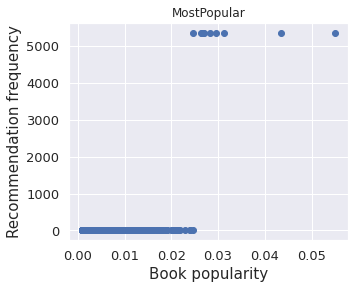

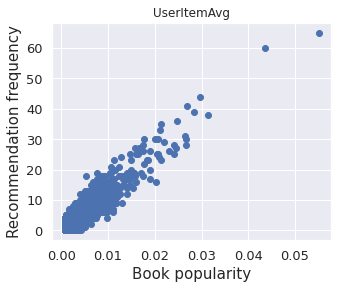

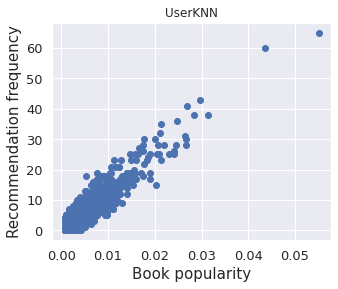

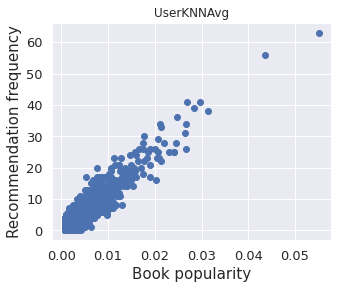

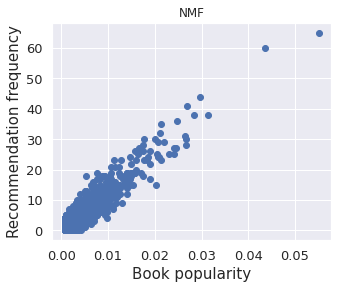

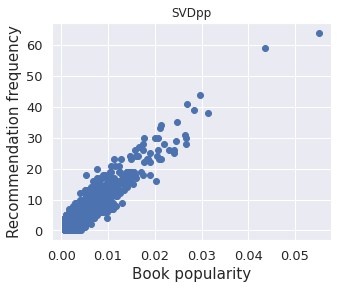

In [ ]:
sns.set(rc = {'figure.figsize':(5,4)})
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist_surprise["count"]
    y = df_item_dist_surprise[algo_names[i]]

    plt.plot(x, y, 'o')
    plt.title(algo_names[i])
    plt.xlabel('Book popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')

In [ ]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algo_names)):
    low_gap_vals.append((low_rec_gap_list_surprise[i] - low_GAP) / low_GAP * 100)
    medium_gap_vals.append((medium_rec_gap_list_surprise[i] - med_GAP) / med_GAP * 100)
    high_gap_vals.append((high_rec_gap_list_surprise[i] - high_GAP) / high_GAP * 100)

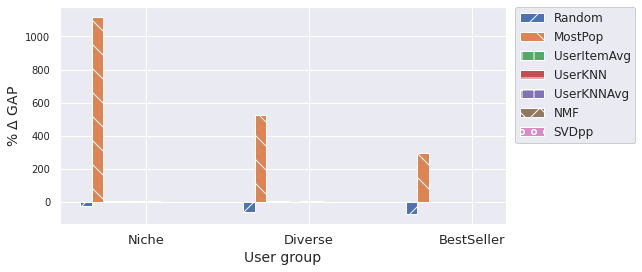

In [ ]:
sns.set(rc = {'figure.figsize':(8,4)})

# set width of bar
barWidth = 0.07

# set height of bar
bars1 = [low_gap_vals[0], medium_gap_vals[0], high_gap_vals[0]]
bars2 = [low_gap_vals[1], medium_gap_vals[1], high_gap_vals[1]]
bars3 = [low_gap_vals[2], medium_gap_vals[2], high_gap_vals[2]]
bars4 = [low_gap_vals[3], medium_gap_vals[3], high_gap_vals[3]]
bars5 = [low_gap_vals[4], medium_gap_vals[4], high_gap_vals[4]]
bars6 = [low_gap_vals[5], medium_gap_vals[5], high_gap_vals[5]]
bars7 = [low_gap_vals[6], medium_gap_vals[6], high_gap_vals[6]]


# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]


# algo_names = ['Random',
#                   'MostPopular',
#                   'UserItemAvg',
#                   'UserKNN',
#                   #"ItemKNN",
#                   'UserKNNAvg',
#                   'NMF',
#                   'SVDpp']
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--"]
# Make the plot
plt.bar(r1, bars1, width=barWidth, label='Random', hatch=patterns[0])
plt.bar(r2, bars2, width=barWidth, label='MostPop', hatch=patterns[1])
plt.bar(r3, bars3, width=barWidth, label='UserItemAvg', hatch=patterns[2])
plt.bar(r4, bars4, width=barWidth, label='UserKNN', hatch=patterns[3])
plt.bar(r5, bars5, width=barWidth, label='UserKNNAvg', hatch=patterns[4])
plt.bar(r6, bars6, width=barWidth, label='NMF', hatch=patterns[5])
plt.bar(r7, bars7, width=barWidth, label='SVDpp', hatch=patterns[6])


# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='14')
plt.ylabel('% $\Delta$ GAP', fontsize='14')
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ['Niche', 'Diverse', 'BestSeller'], fontsize='13')
plt.yticks(fontsize='10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
plt.show()